In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
import scipy.signal as sg

In [2]:
with open('datasets/activity_labels.txt') as f:
	defined_labels = [line.strip().split(" ")[1] for line in f]

In [3]:
lookup = pd.read_csv('datasets/RawData/labels.txt', sep = ' ', header = None)
lookup.columns = ["ExpId", "UserId", "ActId", "Start", "End"]
lookup.head()

,ExpId,UserId,ActId,Start,End
0,1,1,5,250,1232
1,1,1,7,1233,1392
2,1,1,4,1393,2194
3,1,1,8,2195,2359
4,1,1,5,2360,3374


In [4]:
lookup["Duration"] = lookup["End"]-lookup["Start"]
lookup[["ActId","Duration"]].groupby(['ActId']).min()

,Duration
ActId,
1,140
2,221
3,215
4,622
5,759
6,777
7,89
8,73
9,135


In [5]:
lookup["AdjStart"] = round(lookup["Start"] + lookup["Duration"] * 0.05)
lookup["AdjEnd"] = round(lookup["End"]- lookup["Duration"] * 0.05)

In [6]:
lookup["AdjDuration"] = lookup["AdjEnd"]-lookup["AdjStart"]
lookup[["ActId","AdjDuration"]].groupby(['ActId']).min()

,AdjDuration
ActId,
1,126.0
2,199.0
3,193.0
4,560.0
5,683.0
6,699.0
7,81.0
8,65.0
9,121.0


In [20]:
expid = 0
userid = 0
test = [28, 8, 21, 3]
x_train = []
x_val = []
x_test = []
y_train = []
y_val = []
y_test = []
for _,row in lookup.iterrows():
	if expid != row["ExpId"] or userid != row["UserId"]:
		expid = int(row["ExpId"])
		userid = int(row["UserId"])
		acc_file = f'datasets/RawData/acc_exp{"{:02d}".format(expid)}_user{"{:02d}".format(userid)}.txt'
		gyro_file = f'datasets/RawData/gyro_exp{"{:02d}".format(expid)}_user{"{:02d}".format(userid)}.txt'
		acc = pd.read_csv(acc_file, sep = ' ', header = None)
		acc.columns = ["ax", "ay", "az"]
		gyro = pd.read_csv(gyro_file, sep = ' ', header = None)
		gyro.columns = ["gx", "gy", "gz"]
		data = pd.concat([acc, gyro], axis=1)
	for i in range(int(row["AdjStart"]), int(row["AdjEnd"]), 64):
		if userid in test:
			x_test.append(data[i:i+64])
			y_test.append(row["ActId"]-1)
		else:
			x_train.append(data[i:i+64])
			y_train.append(row["ActId"]-1)

In [42]:
columns = itertools.product(["ax", "ay", "az", "gx", "gy", "gz"], ["mean", "std", "freq"])
columns = [t[0]+"_"+t[1] for t in columns]

In [82]:
train_df = pd.DataFrame(columns=columns)
for item, label in zip(x_train, y_train):
	dt = dict()
	for column in item:
		arr = item[column]
		mean = np.mean(arr)
		std = np.std(arr)
		f, Pxx_den = sg.periodogram(arr, fs=50, scaling="spectrum")
		max_freq = np.max(Pxx_den)
		i, = np.where(Pxx_den == max_freq)
		freq = f[i][0]
		dt[column+"_mean"] = mean
		dt[column+"_std"] = std
		dt[column+"_freq"] = freq
	train_df = train_df.append(dt, ignore_index=True)

In [83]:
test_df = pd.DataFrame(columns=columns)
for item, label in zip(x_test, y_test):
	dt = dict()
	for column in item:
		arr = item[column]
		mean = np.mean(arr)
		std = np.std(arr)
		f, Pxx_den = sg.periodogram(arr, fs=50, scaling="spectrum")
		max_freq = np.max(Pxx_den)
		i, = np.where(Pxx_den == max_freq)
		freq = f[i][0]
		dt[column+"_mean"] = mean
		dt[column+"_std"] = std
		dt[column+"_freq"] = freq
	test_df = test_df.append(dt, ignore_index=True)

In [84]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(train_df, y_train)

SVC()

In [85]:
pred = svc.predict(test_df)

In [86]:
pred = pred.astype(int)
true = np.array(y_test).astype(int)

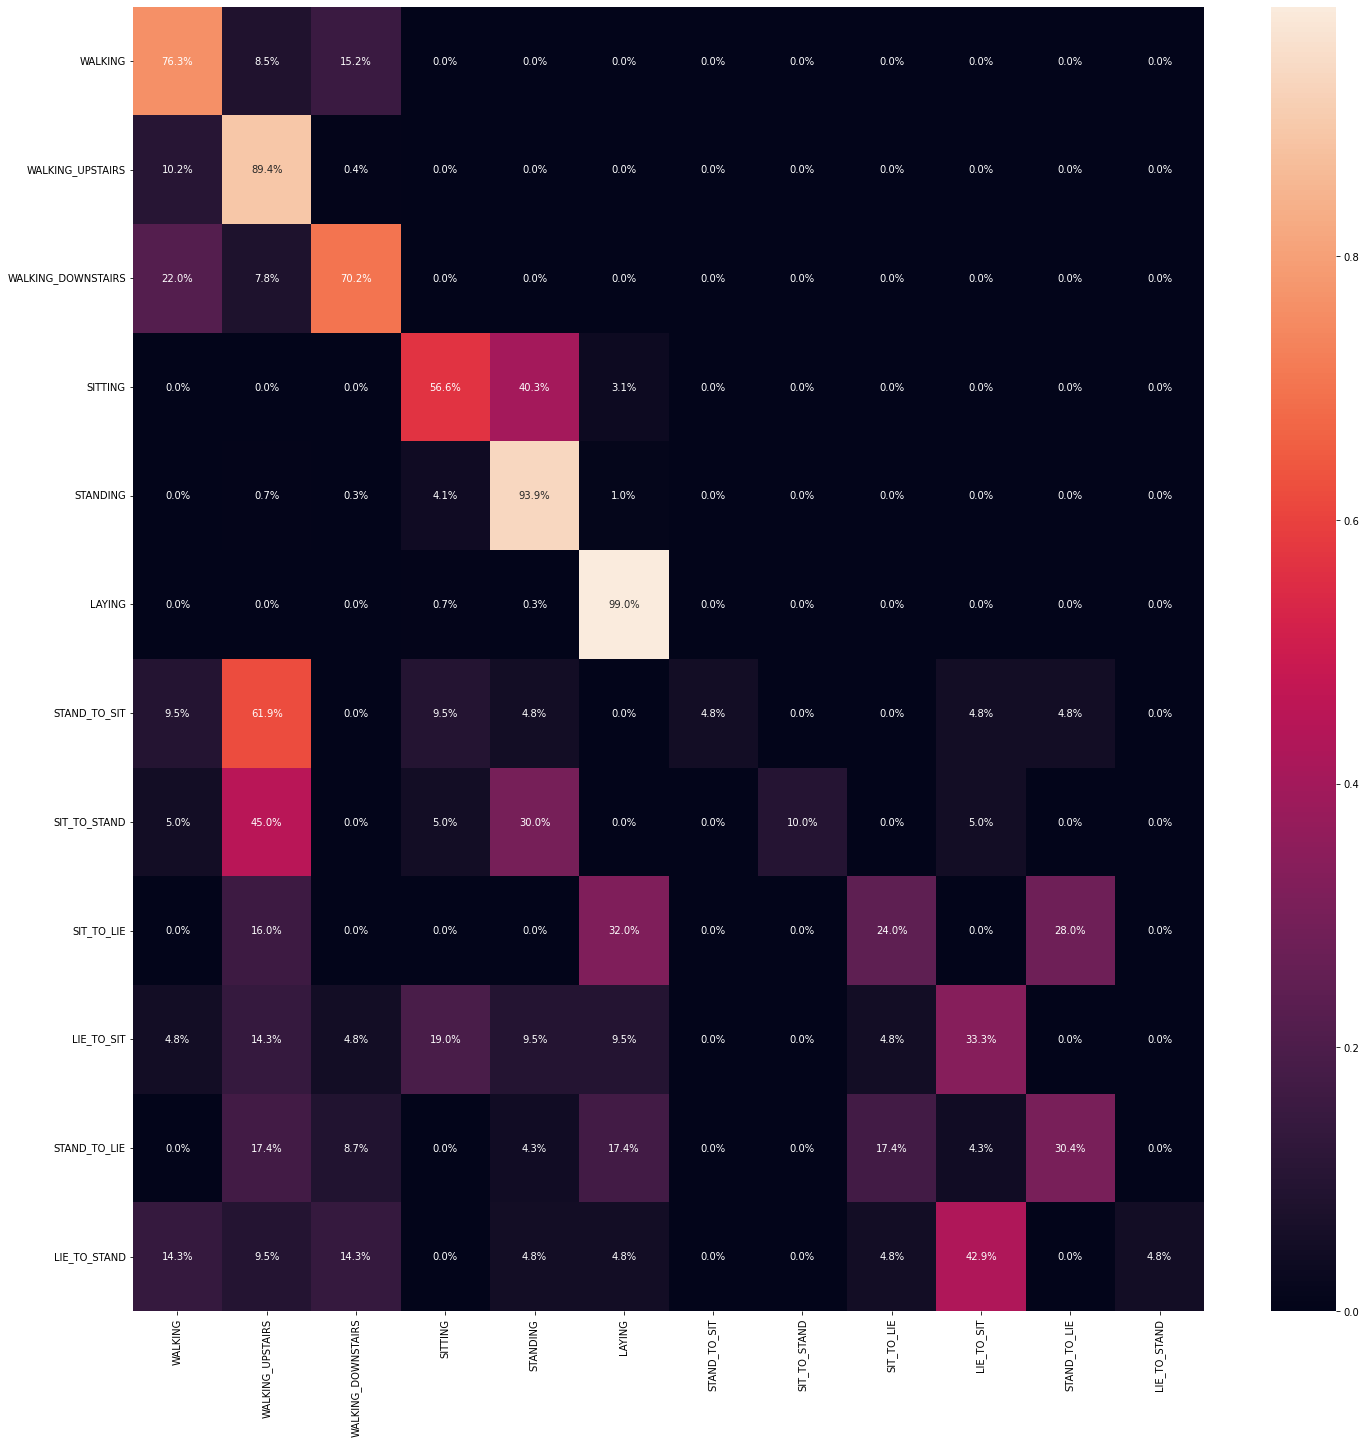

In [87]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(true, pred, labels = range(12), normalize='true')
plt.figure(figsize=(24, 24))
cfm_plot = sb.heatmap(cf_matrix, annot=True, xticklabels=defined_labels, yticklabels=defined_labels, fmt='.1%')
plt.show()

In [88]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
crep = classification_report(true, pred, labels=range(12), target_names=defined_labels)
print(crep)


Classification Report

                    precision    recall  f1-score   support

           WALKING       0.70      0.76      0.73       224
  WALKING_UPSTAIRS       0.74      0.89      0.81       226
WALKING_DOWNSTAIRS       0.77      0.70      0.74       205
           SITTING       0.87      0.57      0.69       258
          STANDING       0.70      0.94      0.80       293
            LAYING       0.92      0.99      0.95       287
      STAND_TO_SIT       1.00      0.05      0.09        21
      SIT_TO_STAND       1.00      0.10      0.18        20
        SIT_TO_LIE       0.50      0.24      0.32        25
        LIE_TO_SIT       0.37      0.33      0.35        21
      STAND_TO_LIE       0.47      0.30      0.37        23
      LIE_TO_STAND       1.00      0.05      0.09        21

          accuracy                           0.77      1624
         macro avg       0.75      0.49      0.51      1624
      weighted avg       0.78      0.77      0.75      1624

